# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them.



## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 



In [11]:
# Load data
from pathlib import Path
import pandas as pd

# Project root = production/
ROOT = Path.cwd().parents[1]

# Dataset path 
DATA_PATH = ROOT / "05_src" / "data" / "fires" / "forestfires.csv"

# Sanity check
print("Using:", DATA_PATH)
print("Exists:", DATA_PATH.exists())

fires_df = pd.read_csv(DATA_PATH)
fires_df.info()
fires_df.head()


Using: /Users/iplitzel/Desktop/Projects/production/05_src/data/fires/forestfires.csv
Exists: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [12]:
# Load the libraries as required.

# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

# Reproducibility
np.random.seed(42)

# Scikit-learn: model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Scikit-learn: preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn: models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn: metrics (prediction-focused)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt







In [13]:
# Load data
# Load data
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../../05_src/data/fires/forestfires.csv")
fires_df = pd.read_csv(DATA_PATH)

fires_df.info()
fires_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [14]:

X = fires_df.drop(columns="area")
y = fires_df["area"]

# Identify categorical and numerical features
categorical_features = ["month", "day"]

numerical_features = [
    col for col in X.columns if col not in categorical_features
]

# Sanity checks
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)
print("X shape:", X.shape)
print("y shape:", y.shape)


Categorical features: ['month', 'day']
Numerical features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
X shape: (517, 12)
y shape: (517,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (413, 12)
X_test: (104, 12)
y_train: (413,)
y_test: (104,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preproc 1: scale numerical variables + one-hot encode categorical variables
preproc1 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline

# Preproc 2: scale + non-linear transform numerical variables + one-hot encode categorical variables
preproc2 = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("scaler", StandardScaler()),
                ("power", PowerTransformer(method="yeo-johnson"))
            ]),
            numerical_features
        ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [18]:
# Pipeline A = preproc1 + baseline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

pipe_A = Pipeline(steps=[
    ("preprocessing", preproc1),
    ("regressor", Ridge())
])


In [19]:
# Pipeline B = preproc2 + baseline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

pipe_B = Pipeline(steps=[
    ("preprocessing", preproc2),
    ("regressor", Lasso(max_iter=20000))
])

In [20]:
# Pipeline C = preproc1 + advanced model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe_C = Pipeline(steps=[
    ("preprocessing", preproc1),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [21]:
# Pipeline D = preproc2 + advanced model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe_D = Pipeline(steps=[
    ("preprocessing", preproc2),
    ("regressor", RandomForestRegressor(random_state=42))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [22]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

#  MAE (error metric). 
scoring = "neg_mean_absolute_error"
cv = 5

# Each grid has >= 4 combinations
param_grid_A = {
    "regressor__alpha": [0.1, 1.0, 10.0, 100.0]  # 4 combos
}

param_grid_B = {
    "regressor__alpha": [1e-4, 1e-3, 1e-2, 1e-1]  # 4 combos
}

param_grid_C = {
    "regressor__n_estimators": [200, 500],        # 2
    "regressor__max_depth": [None, 10],           # 2 -> 4 combos
}

param_grid_D = {
    "regressor__n_estimators": [200, 500],        # 2
    "regressor__max_depth": [None, 10],           # 2
    "regressor__min_samples_leaf": [1, 2],        # 2 -> 8 combos
}

search_A = GridSearchCV(pipe_A, param_grid_A, scoring=scoring, cv=cv, n_jobs=-1)
search_B = GridSearchCV(pipe_B, param_grid_B, scoring=scoring, cv=cv, n_jobs=-1)
search_C = GridSearchCV(pipe_C, param_grid_C, scoring=scoring, cv=cv, n_jobs=-1)
search_D = GridSearchCV(pipe_D, param_grid_D, scoring=scoring, cv=cv, n_jobs=-1)

searches = {
    "Pipeline A (preproc1 + Ridge)": search_A,
    "Pipeline B (preproc2 + Lasso)": search_B,
    "Pipeline C (preproc1 + RF)": search_C,
    "Pipeline D (preproc2 + RF)": search_D,
}

results = []

for name, gs in searches.items():
    gs.fit(X_train, y_train)
    results.append({
        "pipeline": name,
        "best_cv_mae": -gs.best_score_,  # convert back to positive MAE
        "best_params": gs.best_params_,
        "n_combinations_tested": len(gs.cv_results_["params"])
    })

results_df = pd.DataFrame(results).sort_values("best_cv_mae").reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
results_df

,pipeline,best_cv_mae,best_params,n_combinations_tested
0,Pipeline A (preproc1 + Ridge),16.604662,{'regressor__alpha': 100.0},4
1,Pipeline B (preproc2 + Lasso),17.533146,{'regressor__alpha': 0.1},4
2,Pipeline D (preproc2 + RF),18.093349,"{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 500}",8
3,Pipeline C (preproc1 + RF),20.253900,"{'regressor__max_depth': 10, 'regressor__n_estimators': 500}",4


# Evaluate

+ Which model has the best performance?

Pipeline A (preproc1 + Ridge) achieved the lowest cross-validated MAE (16.60), outperforming the other linear and tree-based models. As a result, it was selected as the best-performing model.


# Export

+ Save the best performing model to a pickle file.

In [23]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Recreate the best-performing model with optimal hyperparameters
best_model = Pipeline(steps=[
    ("preprocessing", preproc1),
    ("regressor", Ridge(alpha=100.0))
])

# Fit on the full training data
best_model.fit(X_train, y_train)

# Save the model to a pickle file
with open("best_forestfire_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved as best_forestfire_model.pkl")

Best model saved as best_forestfire_model.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [24]:
import shap
import numpy as np
import pandas as pd

# Use the fitted best model

best_model.fit(X_train, y_train)

# Transform data using the preprocessing step
X_train_trans = best_model.named_steps["preprocessing"].transform(X_train)
X_test_trans = best_model.named_steps["preprocessing"].transform(X_test)

# Get feature names after preprocessing
feature_names = best_model.named_steps["preprocessing"].get_feature_names_out()

# Convert to DataFrame (for readability)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

# Create SHAP explainer for linear model
ridge = best_model.named_steps["regressor"]
explainer = shap.LinearExplainer(
    ridge,
    X_train_trans,
    feature_perturbation="interventional"
)

shap_values = explainer(X_test_trans)

/Users/iplitzel/Desktop/Projects/production/venv/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


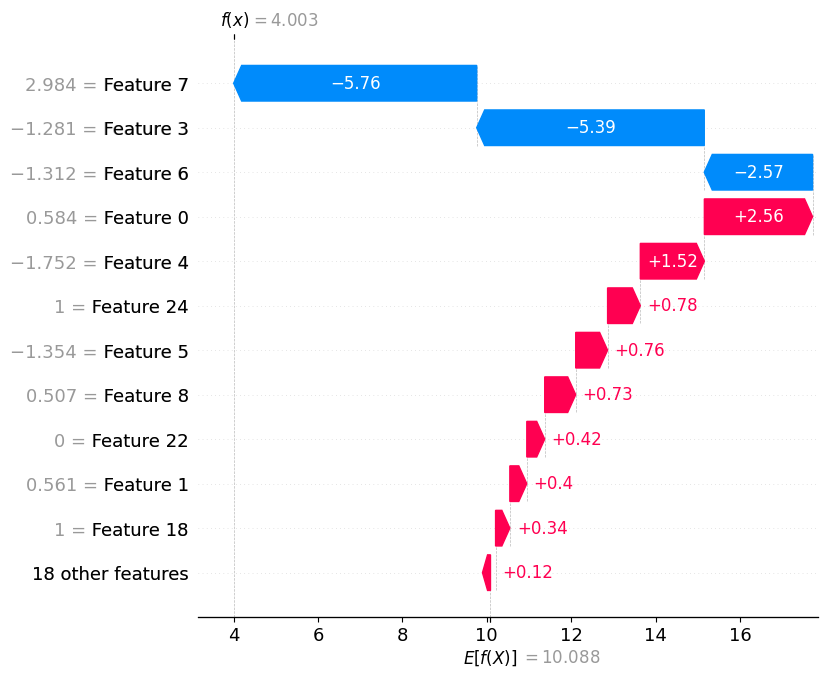

In [25]:
# Select one observation from the test set
i = 0  

shap.plots.waterfall(shap_values[i], max_display=12)

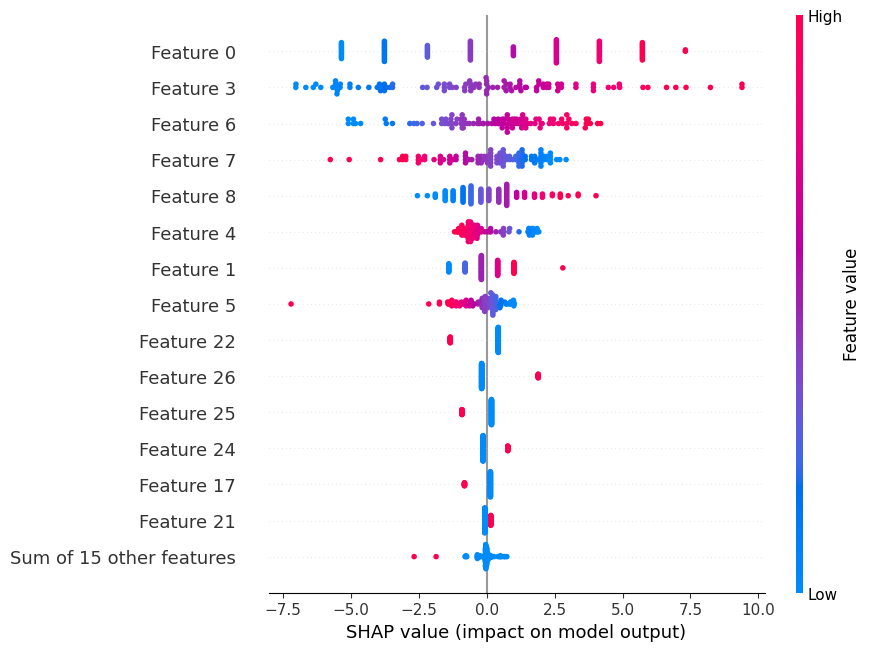

In [26]:
shap.plots.beeswarm(shap_values, max_display=15)

In [27]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

importance.head(10), importance.tail(10)

(         feature  mean_abs_shap
 0         num__X       3.370281
 3       num__DMC       2.983354
 6      num__temp       1.814296
 7        num__RH       1.404480
 8      num__wind       1.061424
 4        num__DC       0.808054
 1         num__Y       0.629947
 5       num__ISI       0.606542
 22  cat__day_fri       0.600942
 26  cat__day_thu       0.417336,
            feature  mean_abs_shap
 12  cat__month_dec       0.026874
 11  cat__month_aug       0.026178
 2        num__FFMC       0.026148
 23    cat__day_mon       0.018191
 10  cat__month_apr       0.012926
 28    cat__day_wed       0.006286
 20  cat__month_oct       0.003926
 18  cat__month_may       0.003250
 14  cat__month_jan       0.001586
 19  cat__month_nov       0.000000)

*(Answer here.)*


For the selected test observation, SHAP values show how each feature contributes to the model’s prediction compared to the average prediction, which is around 10.09. Some features push the prediction up, while others push it down.

For this observation, the most important features are X (spatial coordinate), DMC, and temperature, since they have the largest SHAP values. These features mainly reduce the predicted burned area relative to the baseline. Other features such as wind, relative humidity (RH), and DC increase the prediction slightly, but their impact is smaller. Most of the remaining features have SHAP values close to zero, meaning they have little effect on this prediction.

Overall, the model is mostly driven by a small set of features, including spatial location and key weather variables like DMC, temperature, RH, wind, DC, and ISI. In contrast, many month and day indicators, as well as FFMC, have very low SHAP values and contribute little to the predictions.
Based on this, features with consistently low SHAP values could be removed. To confirm this, I would retrain the model without them and compare the MAE. If performance stays the same or improves, it would show that these features are not necessary.


I used GridSearchCV with scoring='neg_mean_absolute_error' as recommended in the scikit-learn model evaluation documentation (scikit-learn.org).
SHAP values were computed using SHAP’s LinearExplainer as described in the SHAP documentation.

References

scikit-learn documentation. Pipelines and composite estimators.
https://scikit-learn.org/stable/modules/compose.html
scikit-learn documentation. Pipeline.
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
scikit-learn documentation. ColumnTransformer.
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
scikit-learn documentation. Model selection and evaluation.
https://scikit-learn.org/stable/modules/model_evaluation.html
scikit-learn documentation. GridSearchCV.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
scikit-learn documentation. Regression metrics.
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
scikit-learn documentation. Ridge regression.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
scikit-learn documentation. Lasso regression.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
scikit-learn documentation. RandomForestRegressor.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
Lundberg, S. M., and Lee, S. I. (2017). A unified approach to interpreting model predictions.
Advances in Neural Information Processing Systems (NeurIPS).
https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf
SHAP documentation. SHAP: Explainable AI.
https://shap.readthedocs.io/en/latest/
UCI Machine Learning Repository. Forest Fires Data Set.
https://archive.ics.uci.edu/dataset/162/forest+fires

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.